In [1]:
UPLOAD_FOLDER = 'My Drive/wheelie_training/'
FIG_FOLDER = 'ml/label/'
MODEL_FOLDER = 'label/'

# data and training parameters
GET_ONE_I_PREPARED_EARLIER = True
session_count = 2
PREVIOUS_TIMESTEP = True
MAJORITY_UNDERSAMPLING = True
NORMALISE = False

import matplotlib
primary_cmap = matplotlib.cm.get_cmap('cool')
secondary_cmap = matplotlib.cm.get_cmap('Wistia')
tertiary_cmap = matplotlib.cm.get_cmap('summer')

In [2]:
GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CSV_EXT = '*.csv'
PROC_ROOT = RAW_ROOT + 'processed/'
FIG_ROOT = RAW_ROOT + 'figures/'
FIG_DIR = FIG_ROOT + FIG_FOLDER
MODEL_ROOT = RAW_ROOT + 'models/'
MODEL_DIR = MODEL_ROOT + MODEL_FOLDER

## Work with files

In [ ]:
from google.colab import drive
drive.mount(GDRIVE_ROOT)

In [ ]:
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pytz

!pip install python-rle
import rle

def get_df_raw(fname):
  return pd.read_csv(RAW_ROOT + fname)

proc_dfs = {}
def get_df_proc(fname):
  if not fname in proc_dfs.keys():
    proc_dfs[fname] = pd.read_csv(PROC_ROOT + fname)
  return proc_dfs[fname]

def put_df(df, fname):
  Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
  df.to_csv(MODEL_DIR + fname)

def get_fname(file):
  return file.split('/')[-1]

def put_fig(name):
  Path(FIG_DIR).mkdir(parents=True, exist_ok=True)
  plt.savefig(FIG_DIR + name + '.png')

def fromtimestamp_mel(ts):
  return datetime.datetime.fromtimestamp(ts, tz=pytz.timezone('Australia/Melbourne'))

## Get data and work with time

In [5]:
accum = get_df_proc('accum.csv')
if not 'wnum' in accum.columns:
  accum.index = pd.Series(range(len(accum.index)), name='wnum')
accum['datetime'] = accum['timestamp'].apply(fromtimestamp_mel)

## ML utilities

In [6]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

def cm_img(y_true, y_pred, ax, classes=[1, 0], desc='Evaluation'):
  cmf = np.flip(confusion_matrix(y_true, y_pred))
  fscore = precision_recall_fscore_support(y_true, y_pred, labels=classes, average='binary')[2]
  ascore = accuracy_score(y_true, y_pred)
  im = ax.imshow(cmf, cmap=secondary_cmap)
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top') 
  ax.set_xticks(classes)
  ax.set_yticks(classes)
  ax.set_xticklabels(reversed(classes))
  ax.set_yticklabels(reversed(classes))
  ax.set_xlabel('Pred')
  ax.set_ylabel('True')
  ax.set_title('{}\nAccuracy {:.3f}, F-Score {:.3f}'.format(desc, ascore, fscore), y=-0.3)
  for i in range(cmf.shape[0]):
    for j in range(cmf.shape[1]):
      text = ax.text(j, i, cmf[i, j], ha="center", va="center")

# Label wheelies with ML

In [7]:
# inputs to the model
features = ['accelerometerAccelerationX',
            'accelerometerAccelerationY',
            'accelerometerAccelerationZ']

# label we will train to
original_label = 'wheel_up'

In [8]:
# get some sessions data
sessions_df = pd.DataFrame()
if GET_ONE_I_PREPARED_EARLIER:
  sessions_df = pd.read_csv(MODEL_DIR + 'accel_label_{}_sessions.csv'.format(session_count))
else:
  fnames = [get_fname(f) for f in accum['source'].unique()]
  sessions_df = pd.concat([get_df_proc(f) for f in fnames[-session_count:]])
  cache_df = sessions_df[features + [original_label]]
  put_df(cache_df, 'accel_label_{}_sessions.csv'.format(session_count))

In [9]:
y = np.array(sessions_df[original_label])
X = np.array(sessions_df[features]).reshape(-1, len(features))

In [10]:
# add prev timestep
# note we could drop rows where this rolls over discontinuities between sessions
if PREVIOUS_TIMESTEP:
  X_prev = np.roll(X, 1, axis=0)
  X = np.concatenate((X_prev, X), axis=1)
print('input shape: {}'.format(X.shape))

# majority class undersampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
print('Raw class breakdown: {}'.format(Counter(y)))
if MAJORITY_UNDERSAMPLING:
  undersample = RandomUnderSampler(random_state=42)
  X, y = undersample.fit_resample(X, y)
  print('After undersampling: {}'.format(Counter(y)))

input shape: (37758, 6)
Raw class breakdown: Counter({0: 33831, 1: 3927})
After undersampling: Counter({0: 3927, 1: 3927})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


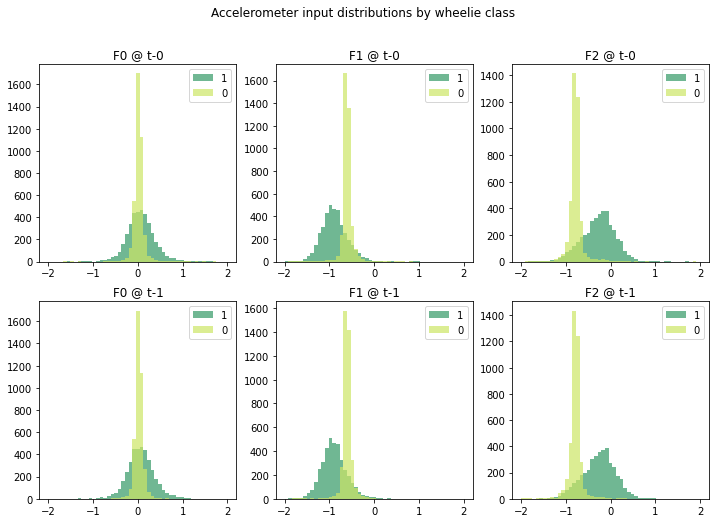

In [11]:
subplot_cols = len(features)
subplot_rows = X.shape[1] // subplot_cols
fig, ax = plt.subplots(subplot_rows, subplot_cols)
fig.set_figwidth(12)
fig.set_figheight(4 * subplot_rows)
fig.suptitle('Accelerometer input distributions by wheelie class')
for i in range(X.shape[1]):
  ax_id = ax[i % subplot_cols] if subplot_rows == 1 else ax[i // subplot_cols][i % subplot_cols]
  y_1_id = np.argwhere(y > 0)
  y_0_id = np.argwhere(y < 1)
  ax_id.hist(X[y_1_id, i], bins=np.linspace(-2, 2, 50), alpha=0.7, color=tertiary_cmap(0.2))
  ax_id.hist(X[y_0_id, i], bins=np.linspace(-2, 2, 50), alpha=0.7, color=tertiary_cmap(0.8))
  ax_id.set_title('F{} @ t-{}'.format(i % subplot_cols, i // subplot_cols))
  ax_id.legend(['1', '0'])
plt.show()

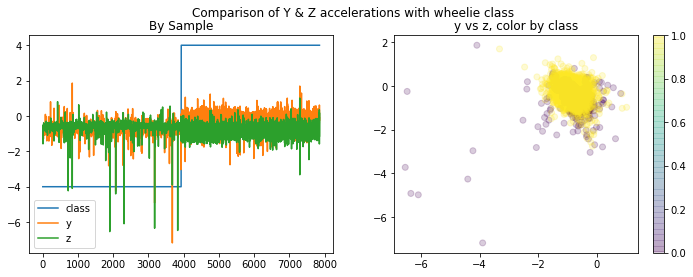

In [12]:
def visual_scale_y(y_val):
  return y_val * 8 - 4;

index_accel_y = 1;
index_accel_z = 2;
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle('Comparison of Y & Z accelerations with wheelie class')
ax[0].plot(visual_scale_y(y))
ax[0].plot(X[:,index_accel_z])
ax[0].plot(X[:,index_accel_y])
ax[0].set_title('By Sample')
ax[0].legend(['class', 'y', 'z'])
sc = ax[1].scatter(X[:,index_accel_y], X[:,index_accel_z], c=y, alpha=0.2)
ax[1].set_title('y vs z, color by class')
plt.colorbar(sc)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
# normalise
from scipy.stats import norm
norm_params = np.array([norm.fit(X_train[:,i]) for i in range(X.shape[1])])
if NORMALISE:
  X_train = (X_train - norm_params[:,0]) / norm_params[:,1]
  X_test = (X_test - norm_params[:,0]) / norm_params[:,1]
print('Performed normalisation: {}'.format(NORMALISE))
print(norm_params)

Performed normalisation: False
[[ 0.04184072  0.23712943]
 [-0.75674233  0.31702173]
 [-0.53290722  0.42451764]
 [ 0.04262741  0.24618426]
 [-0.75393035  0.30171027]
 [-0.53425504  0.44859057]]


In [15]:
param_desc = 't-1: {}, under: {}, norm: {}'.format(PREVIOUS_TIMESTEP, MAJORITY_UNDERSAMPLING, NORMALISE)

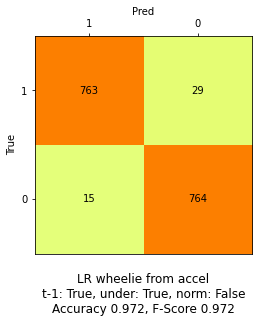

In [16]:
from sklearn.linear_model import LogisticRegression

label_model = LogisticRegression(solver='lbfgs')
label_model.fit(X_train, y_train)

y_pred = label_model.predict(X_test)
cm_img(y_test, y_pred, plt.gca(), desc='LR wheelie from accel\n{}'.format(param_desc))
put_fig('log_regr_conf')
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

x_tf = tf.keras.Input(shape=(6,))
y_tf_predicted = x_tf
y_tf_predicted = layers.Dense(12, activation='relu')(y_tf_predicted)
y_tf_predicted = layers.Dense(1, activation='sigmoid')(y_tf_predicted)
nn_model = tf.keras.Model(inputs=x_tf, outputs=y_tf_predicted)
print(nn_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                84        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
None


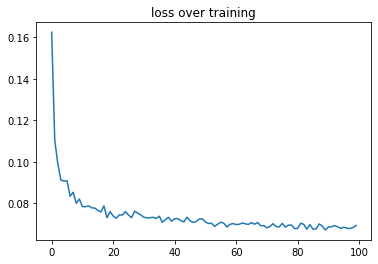

In [18]:
nn_model.compile(optimizer=tf.optimizers.SGD(learning_rate=1.0),
              loss=losses.binary_crossentropy)
history = nn_model.fit(x=X_train, y=y_train, epochs=100, verbose=0)
plt.plot(history.history['loss'])
plt.title("loss over training")
plt.show()

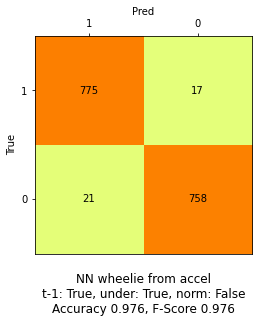

In [19]:
y_pred_tf = nn_model.predict(x=X_test)

def threshold(pred):
  return pred > 0.5

cm_img(y_test, [threshold(y) for y in y_pred_tf], plt.gca(), desc='NN wheelie from accel\n{}'.format(param_desc))
put_fig('nn_conf')
plt.show()

In [20]:
import h5py
nn_model.save(MODEL_DIR + 'keras_model_2.h5')